In [73]:
DATA_PATH_TRAIN = './data/train.csv'
DATA_PATH_TEST = './data/test.csv'

In [162]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt

import sklearn
import xgboost

from tensorflow import keras

In [225]:
df = pd.read_csv(os.path.join(DATA_PATH_TRAIN))

In [226]:
# The columns that contains too much missing values
missingcols = df.columns[np.where(df.isna().sum()/len(df) > 0.2)[0]]
missingcols

Index(['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], dtype='object')

In [227]:
print(df['Alley'].value_counts())

Grvl    50
Pave    41
Name: Alley, dtype: int64


In [228]:
df[missingcols] = df[missingcols].fillna('NA')

In [229]:
df.columns[np.where(df.isna().sum()>0)[0]]

Index(['LotFrontage', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual',
       'GarageCond'],
      dtype='object')

In [230]:
# Going over the nans columns one by one and see if I can replace nans with some value that makes sense or totaly remove them
df['LotFrontage'] = df['LotFrontage'].fillna(0.0)
df['MasVnrType'] = df['MasVnrType'].fillna('NA') # Replace nans with 'NA'
df.loc[(df['MasVnrType']=='None'),'MasVnrType'] = 'NA' # Update the None values with NA as well to keep the same NA valye

df['MasVnrArea'] = df['MasVnrArea'].fillna(0.0)
df['BsmtQual'] = df['BsmtQual'].fillna('NA')
df['BsmtCond'] = df['BsmtCond'].fillna('NA')
df['BsmtExposure'] = df['BsmtExposure'].fillna('NA')
df['BsmtFinType1'] = df['BsmtFinType1'].fillna('NA')
df['BsmtFinType2'] = df['BsmtFinType2'].fillna('NA')
df.drop(df.index[np.where(df['Electrical'].isna())[0]], inplace=True) # Only one entry is missing
df['GarageType'] = df['GarageType'].fillna('NA') 
# GarageYrBlt is handled in a following cell
df['GarageFinish'] = df['GarageFinish'].fillna('NA')
df['GarageQual'] = df['GarageQual'].fillna('NA')
df['GarageCond'] = df['GarageCond'].fillna('NA')


In [231]:
df['GarageYrBlt'].nunique()

97

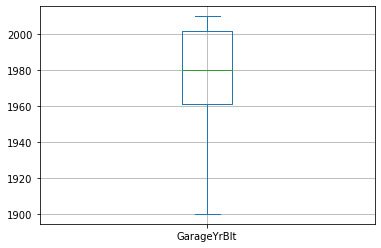

In [232]:
df['GarageYrBlt'].plot(kind='box')
plt.grid(axis='both')

In [233]:
def garageYear2Cat(x):
    if np.isnan(x):
        return 'NA'
    
    if x<1963:
        return 'old'
    if (x>=1963) and (x<=1999):
        return 'moderate'
    else:
        return 'new'


In [234]:
df['GarageYrBlt'] = df['GarageYrBlt'].apply(garageYear2Cat)

In [235]:
df['GarageYrBlt'].value_counts()

moderate    609
new         401
old         368
NA           81
Name: GarageYrBlt, dtype: int64

In [236]:
df[df.columns[np.where(df.isna().sum()>0)[0]]].select_dtypes(include='object').columns

Index([], dtype='object')

In [237]:
# Create a class to handle the preprocessing
class Preprocessor(sklearn.base.TransformerMixin):
    def __init__(self):

        self.catcols = ['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
                       'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu',
                       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC',
                       'Fence', 'MiscFeature']
        self.numcols = ['LotFrontage', 'MasVnrArea']
        self.cols2removerowsfrom = ['Electrical']
        self.cols2remove = []
        
        self.num2cat = ['GarageYrBlt']
        self.num2catfn = [garageYear2Cat]
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        updated_X = X.copy()
        updated_X[self.catcols] = updated_X[self.catcols].fillna('NA')
        updated_X.drop(self.cols2remove, axis=1, inplace=True)
        updated_X.drop(updated_X.index[np.where(updated_X[self.cols2removerowsfrom].isna())[0]], inplace=True)
        
        updated_X[self.numcols] = updated_X[self.numcols].fillna(0.0)
        for col, fn in zip(self.num2cat, self.num2catfn):
            updated_X[col] = updated_X[col].apply(fn)
        
        # Special case
        updated_X['MasVnrType'] = updated_X['MasVnrType'].fillna('NA') # Replace nans with 'NA'
        updated_X.loc[(updated_X['MasVnrType']=='None'),'MasVnrType'] = 'NA' # Update the None values with NA as well to keep the same NA valye

        
        return updated_X
    
    def fit_transform(self, X):
        return self.transform(X)

In [238]:
p = Preprocessor()
X = p.transform(df)

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [239]:
df.equals(X)

True

In [178]:
for col in df.columns:
    if (df[col] != X[col]).sum() > 0:
        print(col)

In [181]:
df.isna().sum().sum() # If it is 0, then we are good to go

0

In [288]:
np.random.seed(101)
df_test = df.sample(frac=0.2)
df_train = df.drop(df_test.index)

In [289]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1,2,20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500
3,4,70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NA,IR1,Lvl,AllPub,...,0,NA,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,8,2007,WD,Normal,307000


In [270]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1167 entries, 1 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1167 non-null   int64  
 1   MSSubClass     1167 non-null   int64  
 2   MSZoning       1167 non-null   object 
 3   LotFrontage    1167 non-null   float64
 4   LotArea        1167 non-null   int64  
 5   Street         1167 non-null   object 
 6   Alley          1167 non-null   object 
 7   LotShape       1167 non-null   object 
 8   LandContour    1167 non-null   object 
 9   Utilities      1167 non-null   object 
 10  LotConfig      1167 non-null   object 
 11  LandSlope      1167 non-null   object 
 12  Neighborhood   1167 non-null   object 
 13  Condition1     1167 non-null   object 
 14  Condition2     1167 non-null   object 
 15  BldgType       1167 non-null   object 
 16  HouseStyle     1167 non-null   object 
 17  OverallQual    1167 non-null   int64  
 18  OverallC

In [290]:
cat_cols = df_train.select_dtypes(include=['object']).columns
num_cols = set(df_train.columns)-set(cat_cols)

In [291]:
len(cat_cols), len(num_cols)

(44, 37)

In [292]:
df_train[cat_cols].nunique().describe()

count    44.000000
mean      6.022727
std       4.008646
min       2.000000
25%       4.000000
50%       5.000000
75%       6.250000
max      25.000000
dtype: float64

In [293]:
col_min_max = {}
for col in cat_cols:
    cnts = df_train[col].value_counts()
    col_min_max[col] = [cnts.min(), cnts.max()]

pd.DataFrame(col_min_max, index=['min','max']).iloc[0,:].describe()
# Picking threshold 20

count    44.000000
mean     13.613636
std      18.064762
min       1.000000
25%       1.000000
50%       5.000000
75%      23.750000
max      73.000000
Name: min, dtype: float64

In [294]:
# First hyper parameter (lower limit to exclude categorical values to limit the date dimensionality)
threshold=20
for col in cat_cols:
    idx = np.where(df_train[col].value_counts() < threshold)
    old_values = df_train[col].value_counts().index[idx]
    df_train[col] = df_train[col].apply(lambda x: 'other' if x in old_values.tolist() else x)

In [295]:
old_values.to_list()

['Family', 'Alloca', 'AdjLand']

In [296]:
# Calculate the new dimensionality
added_dims = 0
for cat in cat_cols:
    added_dims += df_train[cat].nunique()
print(added_dims)

199


In [297]:
ohe_dict = {}
for cat in cat_cols:
    ohe = sklearn.preprocessing.OneHotEncoder(handle_unknown='ignore')
    X_train_cat = pd.DataFrame(ohe.fit_transform(df_train[[cat]]).toarray(), index=df_train.index, columns=ohe.get_feature_names([cat]))
    df_train.drop(cat, axis=1, inplace=True)
    df_train = pd.concat([df_train, X_train_cat], axis=1)
    ohe_dict[cat] = ohe

In [300]:
# Embed the OHE in a class
class CategoricalHandler(sklearn.base.TransformerMixin):
    def __init__(self, catcols=[]):
        self.catcols = catcols
    def fit(self, X, y=None):
        self.ohe_dict_ = {}
        for cat in self.catcols:
            ohe = sklearn.preprocessing.OneHotEncoder(handle_unknown='ignore')
            ohe.fit(X)
            self.ohe_dict_[cat] = ohe
        return self
    
    def transform(self, X):
        uX = X.copy()
        for cat, ohe in self.ohe_dict_.items():
            X_train_cat = pd.DataFrame(ohe.fit_transform(uX[[cat]]).toarray(), index=uX.index, columns=ohe.get_feature_names([cat]))
            uX.drop(cat, axis=1, inplace=True)
            uX = pd.concat([uX, X_train_cat], axis=1)
        return uX
    
    def fit_transform(self, X):
        self.ohe_dict_ = {}
        uX = X.copy()
        for cat in self.catcols:
            ohe = sklearn.preprocessing.OneHotEncoder(handle_unknown='ignore')
            X_train_cat = pd.DataFrame(ohe.fit_transform(uX[[cat]]).toarray(), index=uX.index, columns=ohe.get_feature_names([cat]))
            uX.drop(cat, axis=1, inplace=True)
            uX = pd.concat([uX, X_train_cat], axis=1)
            self.ohe_dict_[cat] = ohe
        return uX
        

In [302]:
# Perform the feature selection